In [1]:
import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import make_scorer, roc_auc_score, roc_curve, RocCurveDisplay
from libcharlotte import process_data, transform_labels, get_start_dates
from matplotlib import pyplot as plt
from xgboost import XGBRegressor
from quantstats.reports import full
from tqdm.auto import tqdm

In [2]:
# read in dataframe
df = pd.read_csv("merged_data.csv", index_col='Date', parse_dates=['Date'])
new_idx = pd.date_range(min(df.index), max(df.index), freq='D')
df = df.reindex(new_idx)
df.tail(15)

crack   ny_gas     wti  crude_prod  crude_rigs  crude_imports  \
2022-06-28  52.660  166.320  113.66         NaN         NaN            NaN   
2022-06-29  48.496  160.146  111.65         NaN         NaN            NaN   
2022-06-30  46.758  154.518  107.76         NaN         NaN            NaN   
2022-07-01  49.804  160.104  110.30         NaN         NaN         6839.0   
2022-07-02     NaN      NaN     NaN         NaN         NaN            NaN   
2022-07-03     NaN      NaN     NaN         NaN         NaN            NaN   
2022-07-04     NaN      NaN     NaN         NaN         NaN            NaN   
2022-07-05  45.114  146.664  101.55         NaN         NaN            NaN   
2022-07-06  42.196  142.506  100.31         NaN         NaN            NaN   
2022-07-07  46.454  151.074  104.62         NaN         NaN            NaN   
2022-07-08  46.310  153.090  106.78         NaN         NaN         6675.0   
2022-07-09     NaN      NaN     NaN         NaN         NaN            NaN   
2022-07-10     NaN      NaN     NaN         NaN         NaN            NaN   
2022-07-11  46.916  153.006  106.09         NaN         NaN            NaN   
2022-07-12  47.966  145.656   97.69         NaN         NaN            NaN   

            crude_exports  products_imports  products_exports  crude_net  \
2022-06-28            NaN               NaN               NaN        NaN   
2022-06-29            NaN               NaN               NaN        NaN   
2022-06-30            NaN               NaN               NaN        NaN   
2022-07-01         2612.0            2167.0            6961.0     4227.0   
2022-07-02            NaN               NaN               NaN        NaN   
2022-07-03            NaN               NaN               NaN        NaN   
2022-07-04            NaN               NaN               NaN        NaN   
2022-07-05            NaN               NaN               NaN        NaN   
2022-07-06            NaN               NaN               NaN        NaN   
2022-07-07            NaN               NaN               NaN        NaN   
2022-07-08         3024.0            2199.0            5827.0     3651.0   
2022-07-09            NaN               NaN               NaN        NaN   
2022-07-10            NaN               NaN               NaN        NaN   
2022-07-11            NaN               NaN               NaN        NaN   
2022-07-12            NaN               NaN               NaN        NaN   

            products_net  crude_inputs  ref_utilization  ref_capacity  \
2022-06-28           NaN           NaN              NaN           NaN   
2022-06-29           NaN           NaN              NaN           NaN   
2022-06-30           NaN           NaN              NaN           NaN   
2022-07-01       -4794.0       16438.0              NaN           NaN   
2022-07-02           NaN           NaN              NaN           NaN   
2022-07-03           NaN           NaN              NaN           NaN   
2022-07-04           NaN           NaN              NaN           NaN   
2022-07-05           NaN           NaN              NaN           NaN   
2022-07-06           NaN           NaN              NaN           NaN   
2022-07-07           NaN           NaN              NaN           NaN   
2022-07-08       -3628.0       16640.0              NaN           NaN   
2022-07-09           NaN           NaN              NaN           NaN   
2022-07-10           NaN           NaN              NaN           NaN   
2022-07-11           NaN           NaN              NaN           NaN   
2022-07-12           NaN           NaN              NaN           NaN   

            crude_reserves  gas_reserves  gas_supplied  
2022-06-28             NaN           NaN           NaN  
2022-06-29             NaN           NaN           NaN  
2022-06-30             NaN           NaN           NaN  
2022-07-01        915828.0      219112.0           NaN  
2022-07-02             NaN           NaN           NaN  
2022-07-03             NaN          

In [ ]:
df.describe()

In [ ]:
get_start_dates(df)

In [5]:
cols = list(df.columns)

cols.remove("crude_net")
cols.remove("products_net")
cols.remove("gas_supplied")

cols

['crack',
 'ny_gas',
 'wti',
 'crude_prod',
 'crude_rigs',
 'crude_imports',
 'crude_exports',
 'products_imports',
 'products_exports',
 'crude_inputs',
 'ref_utilization',
 'ref_capacity',
 'crude_reserves',
 'gas_reserves']

In [6]:
mindex, maxdex, df_proc = process_data(df, cols, 20, [20*i for i in range(7)], "1990-01-01", "2021-12-31")
mindex, maxdex

(datetime.date(1991, 8, 29), datetime.date(2021, 12, 31))

In [ ]:
df_proc.head(10)

In [ ]:
df_proc.describe()

In [9]:
# set the targets
days_forecast = 15

crack_reindex = df.crack.reindex_like(df_proc)
crack_targets = (crack_reindex.shift(-days_forecast)/crack_reindex - 1)[:-days_forecast]
crack_targets = crack_targets.fillna(method = 'ffill')

## Create XGBoost Model

In [10]:
X = df_proc[:-days_forecast]
y = transform_labels(crack_targets, 75)

In [ ]:
y.describe()

In [12]:
model = XGBRegressor(objective='binary:logistic', eval_metric='auc')

ts_cv = TimeSeriesSplit(n_splits=5)

parameters = {
    # "n_estimators": [50, 100, 250, 500], # best is 250 but it barely matters
    # 'max_depth': [2, 4, 6, 10, 20] # best is 4 but it once again doesn't really matter
    # 'alpha' : np.logspace(-3,0, num=4) # doesn't matter a lot
    # 'lambda': np.logspace(-2, 1, num=4) # doesn't matter a lot
}

scorer = make_scorer(roc_auc_score)

gs = GridSearchCV(model, param_grid=parameters, cv=ts_cv, scoring=scorer, verbose=3)
gs.fit(X, y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..................................., score=0.688 total time=   1.9s
[CV 2/5] END ..................................., score=0.715 total time=   1.2s
[CV 3/5] END ..................................., score=0.633 total time=   1.8s
[CV 4/5] END ..................................., score=0.656 total time=   2.0s
[CV 5/5] END ..................................., score=0.640 total time=   2.3s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric='auc',
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,...
                                    learning_rate=None, max_bin=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    objective='binary:logistic', predictor=None,
                                    random_state=None, reg_alpha=None, ...),
             param_grid={}, scoring=make_scorer(roc_auc_score), verbose=3)

In [13]:
gs.cv_results_

{'mean_fit_time': array([1.84903951]),
 'std_fit_time': array([0.36701271]),
 'mean_score_time': array([0.00959797]),
 'std_score_time': array([0.00119624]),
 'params': [{}],
 'split0_test_score': array([0.68796208]),
 'split1_test_score': array([0.71517306]),
 'split2_test_score': array([0.63257156]),
 'split3_test_score': array([0.65557365]),
 'split4_test_score': array([0.63989317]),
 'mean_test_score': array([0.66623471]),
 'std_test_score': array([0.03100898]),
 'rank_test_score': array([1], dtype=int32)}

In [ ]:
model = XGBRegressor(objective = 'binary:logistic')

results = pd.DataFrame()

# dfs = np.linspace(2, 30, 15)
dfs = [20]

for i in tqdm(dfs):
    # set the targets
    days_forecast = int(i)

    crack_reindex = df.crack.reindex_like(df_proc)
    crack_targets = (crack_reindex.shift(-days_forecast)/crack_reindex - 1)[:-days_forecast]
    crack_targets = crack_targets.fillna(method = 'ffill')
    crack_targets = crack_targets.reindex_like(X)

    y = transform_labels(crack_targets, 75)

    cutoff_date = datetime(2012, 1, 1).date()

    X_train = X[X.index <= cutoff_date]
    X_test = X[X.index > cutoff_date]

    y_train = y[y.index <= cutoff_date]
    y_test = y[y.index > cutoff_date]

    model.fit(X_train, y_train)

    results = pd.concat([results, pd.DataFrame([[days_forecast, roc_auc_score(y_test, model.predict(X_test))]], columns=['days', 'roc-auc'])])

results

In [ ]:
results

[]

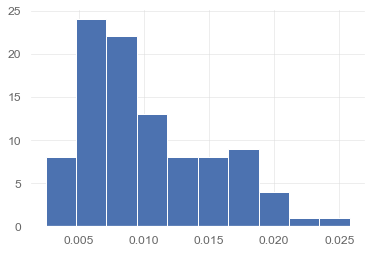

In [55]:
plt.hist(model.feature_importances_)
plt.plot()

In [ ]:
s = np.linspace(0, 1, 100)
y_hat = model.predict(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_hat)
roc_curve_plot = RocCurveDisplay.from_predictions(y_test, y_hat)
plt.plot(s, s, color = 'red')
plt.show()

## Test PCA

In [ ]:
# from sklearn.decomposition import PCA
#
# pca = PCA().fit(X)
# plt.plot(np.cumsum(pca.explained_variance_ratio_))
# plt.xlabel("num comp")
# plt.ylabel("cum explained var")
# plt.plot()

In [ ]:
# X.shape

In [ ]:
# pca.components_

In [ ]:
# pca_reduced = PCA(n_components=10)
# pca_reduced.fit(X)
#
# model_pca = XGBRegressor(objective = 'binary:logistic')
#
# cutoff_date_pca = datetime(2012, 1, 1).date()
#
# X_train_pca = X[X.index <= cutoff_date]
# X_test_pca = X[X.index > cutoff_date]
#
# y_train_pca = y[y.index <= cutoff_date]
# y_test_pca = y[y.index > cutoff_date]
#
# X_train_pca = pca_reduced.transform(X_train_pca)
# X_test_pca = pca_reduced.transform(X_test_pca)
#
# model_pca.fit(X_train_pca, y_train_pca)

In [ ]:
# s_pca = np.linspace(0, 1, 100)
# y_hat_pca = model_pca.predict(X_test_pca)
# fpr_pca, tpr_pca, threshold_pca = roc_curve(y_test_pca, y_hat_pca)
# roc_curve_plot_pca = RocCurveDisplay.from_predictions(y_test_pca, y_hat_pca)
# plt.plot(s_pca, s_pca, color = 'red')
# plt.show()

In [ ]:
# X_test_pca

## Trading Model

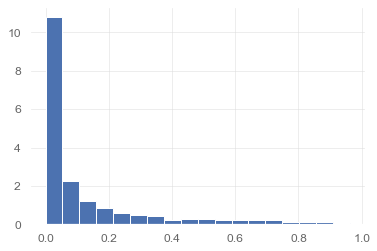

In [30]:
plt.hist(y_hat, bins='doane', density=True)
plt.show()

In [31]:
target_precision = 0.25

trade_decisions = pd.Series(y_hat, name="position")
trade_decisions.index = X_test.index
trade_decisions = trade_decisions.apply(lambda x: int(x >= target_precision))

trade_decisions.head()

2012-01-03    1
2012-01-04    1
2012-01-05    1
2012-01-06    1
2012-01-09    0
Name: position, dtype: int64

In [32]:
trade_decisions.describe()

count    2497.000000
mean        0.170605
std         0.376239
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: position, dtype: float64

In [33]:
crack_returns = df.crack.reindex_like(trade_decisions)
crack_returns = (crack_returns/crack_returns.shift(1) - 1).dropna()
crack_returns

2012-01-04    0.044530
2012-01-05   -0.076080
2012-01-06    0.118249
2012-01-09   -0.002919
2012-01-10   -0.000399
                ...   
2021-11-23    0.092235
2021-11-24   -0.052800
2021-11-30   -0.027783
2021-12-01   -0.042656
2021-12-02    0.116111
Name: crack, Length: 2476, dtype: float64

In [34]:
trade_decisions2 = trade_decisions.reindex_like(crack_returns)
trade_returns = -trade_decisions2*crack_returns
trade_returns.index = pd.DatetimeIndex(trade_returns.index)

In [35]:
trade_returns.head()

2012-01-04   -0.044530
2012-01-05    0.076080
2012-01-06   -0.118249
2012-01-09   -0.000000
2012-01-10   -0.000000
dtype: float64

In [36]:
trade_returns.describe()

count    2476.000000
mean       -0.006845
std         0.566625
min       -27.307692
25%         0.000000
50%        -0.000000
75%         0.000000
max         5.345154
dtype: float64

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2012-01-04  2012-01-04
End Period                 2021-12-02  2021-12-02
Risk-Free Rate             0.0%        0.0%
Time in Market             18.0%       100.0%

Cumulative Return          5,171.67%   332.27%
CAGR﹪                     49.15%      15.91%

Sharpe                     -0.19       1.01
Prob. Sharpe Ratio         20.62%      99.89%
Smart Sharpe               -0.19       1.0
Sortino                    -0.2        1.4
Smart Sortino              -0.19       1.39
Sortino/√2                 -0.14       0.99
Smart Sortino/√2           -0.14       0.98
Omega                      0.62        0.62

Max Drawdown               -1728.67%   -33.72%
Longest DD Days            2532        272
Volatility (ann.)          899.49%     16.07%
R^2                        0.01        0.01
Information Ratio          -0.01       -0.01
Calmar                     0.03       

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2013-04-12  2020-03-17  2020-03-18  2532  -1728.668719        -80.895796
2  2020-03-20  2020-03-25  2020-04-02    13   -143.528401       -116.010315
3  2020-04-09  2020-06-01  2021-12-02   602    -81.516717        -78.495268
4  2013-01-24  2013-02-15  2013-04-02    68    -24.196253        -20.257554
5  2012-06-01  2012-11-08  2012-12-05   187    -16.479891        -15.663465

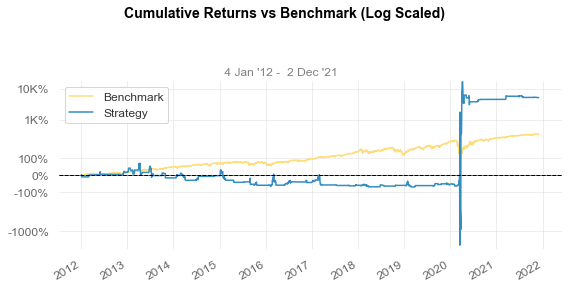

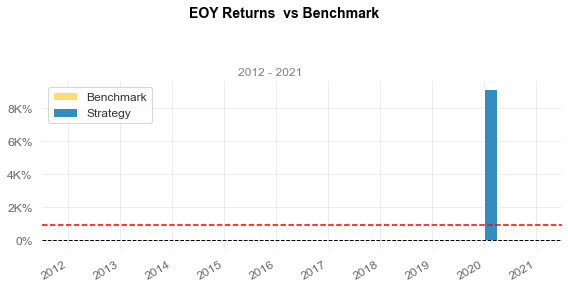

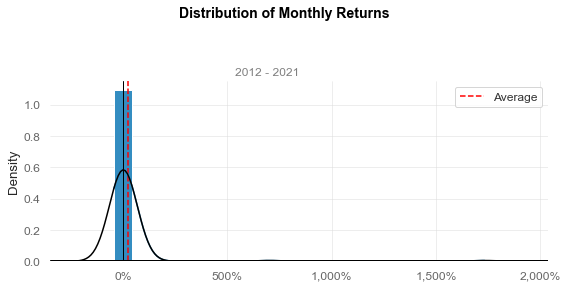

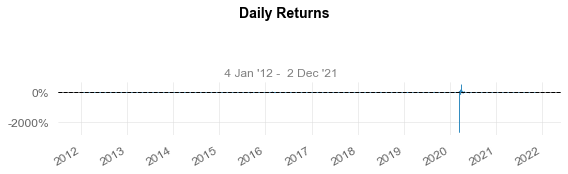

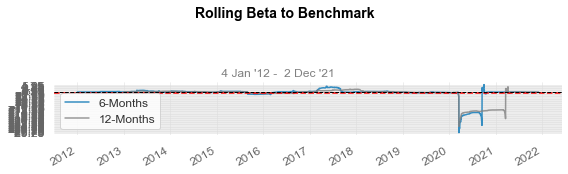

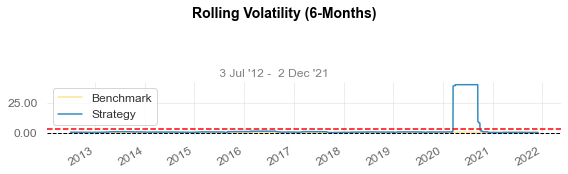

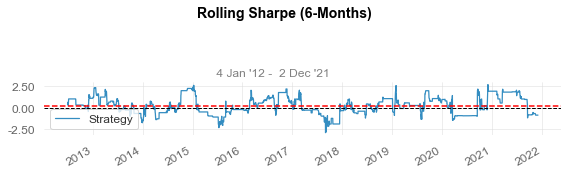

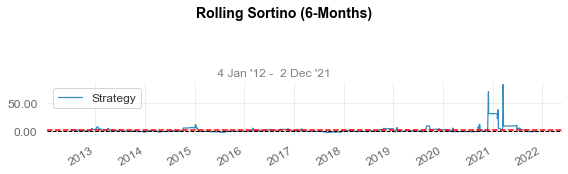

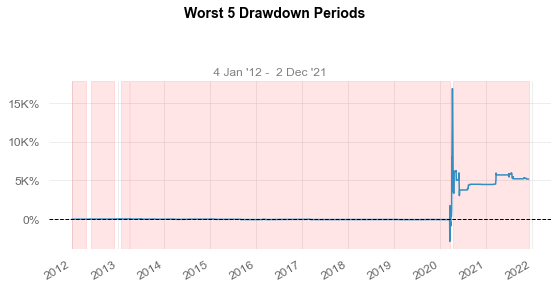

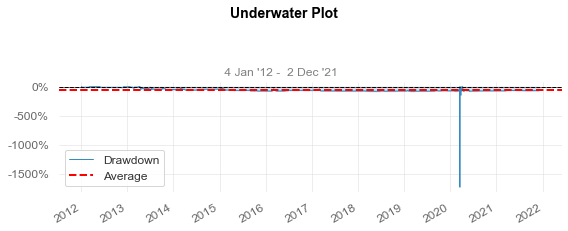

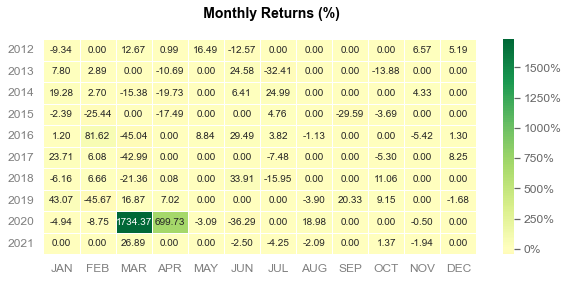

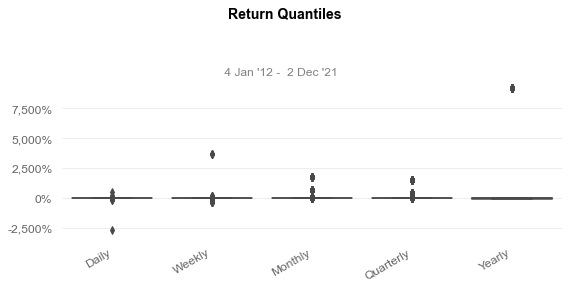

In [37]:
full(trade_returns, 'SPY')